# Step 4: Model Building and Training

In this step, we will train models to detect fraudulent transactions.
We will use stratified train-test splits, handle class imbalance, and evaluate models using appropriate metrics.


In [2]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc

# Imbalanced data
from imblearn.over_sampling import SMOTE

# Ensemble
import xgboost as xgb
import lightgbm as lgb

In [3]:
fraud_df = pd.read_csv("../data/processed/Fraud_Data_cleaned.csv")
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [4]:
# Separate target
X = fraud_df.drop(columns=['class','signup_time','purchase_time','ip_address','user_id','device_id'], errors='ignore')
y = fraud_df['class']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (120889, 5) Test shape: (30223, 5)


In [5]:
# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded  = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align test set with train set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [6]:
num_cols = X_train_encoded.select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
X_train_encoded[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
X_test_encoded[num_cols]  = scaler.transform(X_test_encoded[num_cols])

In [7]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_encoded, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

Before SMOTE:
 class
0    109568
1     11321
Name: count, dtype: int64
After SMOTE:
 class
0    109568
1    109568
Name: count, dtype: int64


In [8]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)

y_pred = lr.predict(X_test_encoded)
y_probs = lr.predict_proba(X_test_encoded)[:,1]

print("F1-Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print("AUC-PR:", pr_auc)


F1-Score: 0.1690174232547114

Confusion Matrix:
 [[14775 12618]
 [ 1404  1426]]
AUC-PR: 0.10261824883756797


In [9]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test_encoded)
y_probs_xgb = xgb_model.predict_proba(X_test_encoded)[:,1]

print("F1-Score (XGB):", f1_score(y_test, y_pred_xgb))
print("\nConfusion Matrix (XGB):\n", confusion_matrix(y_test, y_pred_xgb))

precision, recall, _ = precision_recall_curve(y_test, y_probs_xgb)
pr_auc = auc(recall, precision)
print("AUC-PR (XGB):", pr_auc)


C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1-Score (XGB): 0.1725105621858328

Confusion Matrix (XGB):
 [[  593 26800]
 [   33  2797]]
AUC-PR (XGB): 0.21268446887866868


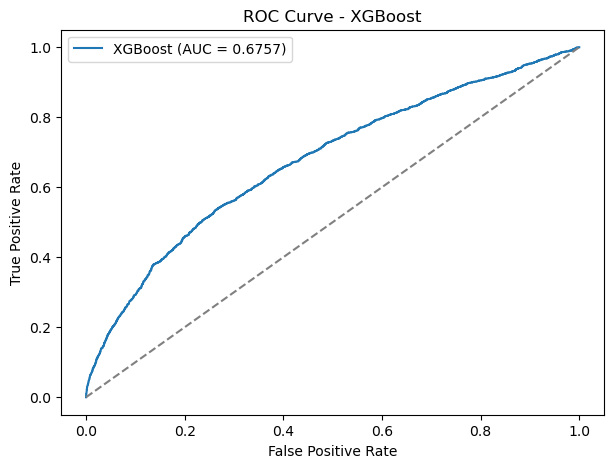

ROC-AUC (XGB): 0.6757318839934734


In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
roc_auc = roc_auc_score(y_test, y_probs_xgb)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

print("ROC-AUC (XGB):", roc_auc)


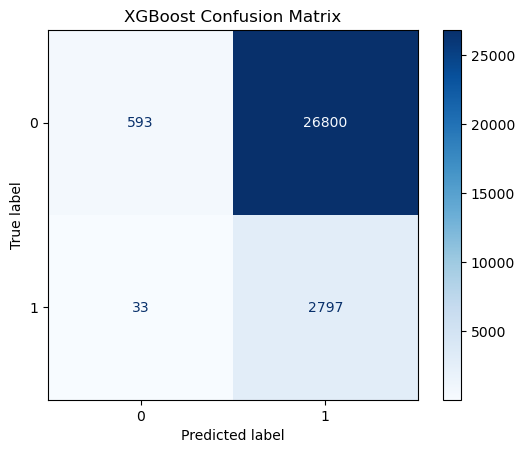

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    cmap="Blues",
    values_format="d"
)

plt.title("XGBoost Confusion Matrix")
plt.show()


In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
pr_aucs = []

for train_index, val_index in skf.split(X_train_encoded, y_train):
    X_tr, X_val = X_train_encoded.iloc[train_index], X_train_encoded.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Fit model
    xgb_model_cv = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=(y_tr==0).sum() / (y_tr==1).sum(),
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model_cv.fit(X_tr, y_tr)
    
    # Predictions
    y_val_pred = xgb_model_cv.predict(X_val)
    y_val_prob = xgb_model_cv.predict_proba(X_val)[:,1]
    
    # Metrics
    f1_scores.append(f1_score(y_val, y_val_pred))
    precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
    pr_aucs.append(auc(recall, precision))

print("Mean F1-Score:", np.mean(f1_scores), "±", np.std(f1_scores))
print("Mean AUC-PR:", np.mean(pr_aucs), "±", np.std(pr_aucs))


C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:21:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:21:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:21:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [13:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Mean F1-Score: 0.2461845093005955 ± 0.005015823365516427
Mean AUC-PR: 0.23183336398004614 ± 0.006137431326657428


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, auc

# Logistic Regression Baseline
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_encoded, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_encoded)
y_probs_lr = lr_model.predict_proba(X_test_encoded)[:,1]

# Metrics
print("F1-Score (Logistic Regression):", f1_score(y_test, y_pred_lr))
print("\nConfusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_lr))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_probs_lr)
pr_auc_lr = auc(recall_lr, precision_lr)
print("AUC-PR (Logistic Regression):", pr_auc_lr)


F1-Score (Logistic Regression): 0.16953199617956066

Confusion Matrix (Logistic Regression):
 [[14891 12502]
 [ 1410  1420]]
AUC-PR (Logistic Regression): 0.10264932428419515


                 Model  F1-Score    AUC-PR
0  Logistic Regression  0.169532  0.102649
1              XGBoost  0.172511  0.212684


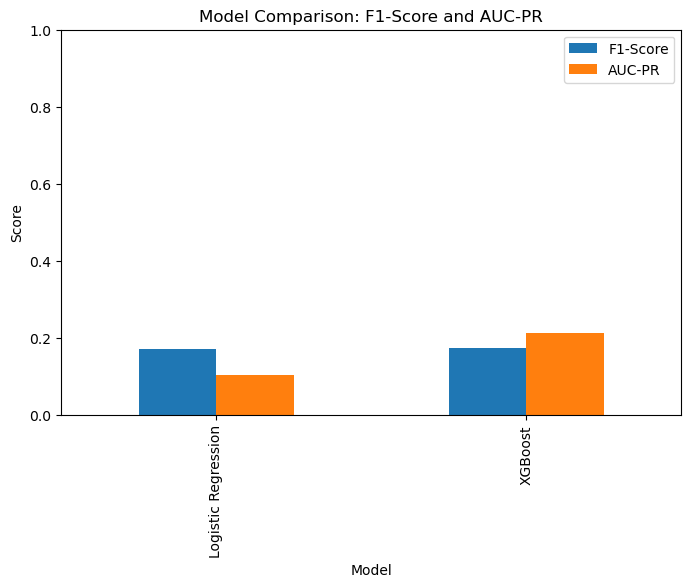

In [14]:
# Model Comparison

models = ['Logistic Regression', 'XGBoost']
f1_scores_mean = [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_xgb)]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_probs_lr)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_probs_xgb)
auc_pr_scores = [auc(recall_lr, precision_lr), auc(recall_xgb, precision_xgb)]

comparison_df = pd.DataFrame({
    'Model': models,
    'F1-Score': f1_scores_mean,
    'AUC-PR': auc_pr_scores
})

print(comparison_df)

# Optional: Bar plot for visualization
import matplotlib.pyplot as plt
comparison_df.set_index('Model').plot(kind='bar', figsize=(8,5))
plt.title('Model Comparison: F1-Score and AUC-PR')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()


In [17]:
from sklearn.metrics import average_precision_score

# Side-by-side comparison with Logistic Regression
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_xgb)],
    'AUC-PR': [
        average_precision_score(y_test, y_probs_lr), 
        average_precision_score(y_test, y_probs_xgb)
    ]
})
print("\nModel Comparison:\n", comparison)

# Explicit Model Selection
best_model = 'XGBoost' if comparison.loc[1, 'F1-Score'] > comparison.loc[0, 'F1-Score'] else 'Logistic Regression'
print("\nSelected Model:", best_model)



Model Comparison:
                  Model  F1-Score    AUC-PR
0  Logistic Regression  0.169532  0.102923
1              XGBoost  0.172511  0.213065

Selected Model: XGBoost
